# Prize Probabilities on a Circular Board

## Problem 

There is a circular board game with 14 spaces, each containing a prize. The player starts on the Start (space 14) and rolls a standard six-sided die $X$ times. After all rolls, the total sum of the dice is $N$. The player then moves clockwise $N$ spaces from the Start position and receives the prize on the space where they land. Each prize has a different value.

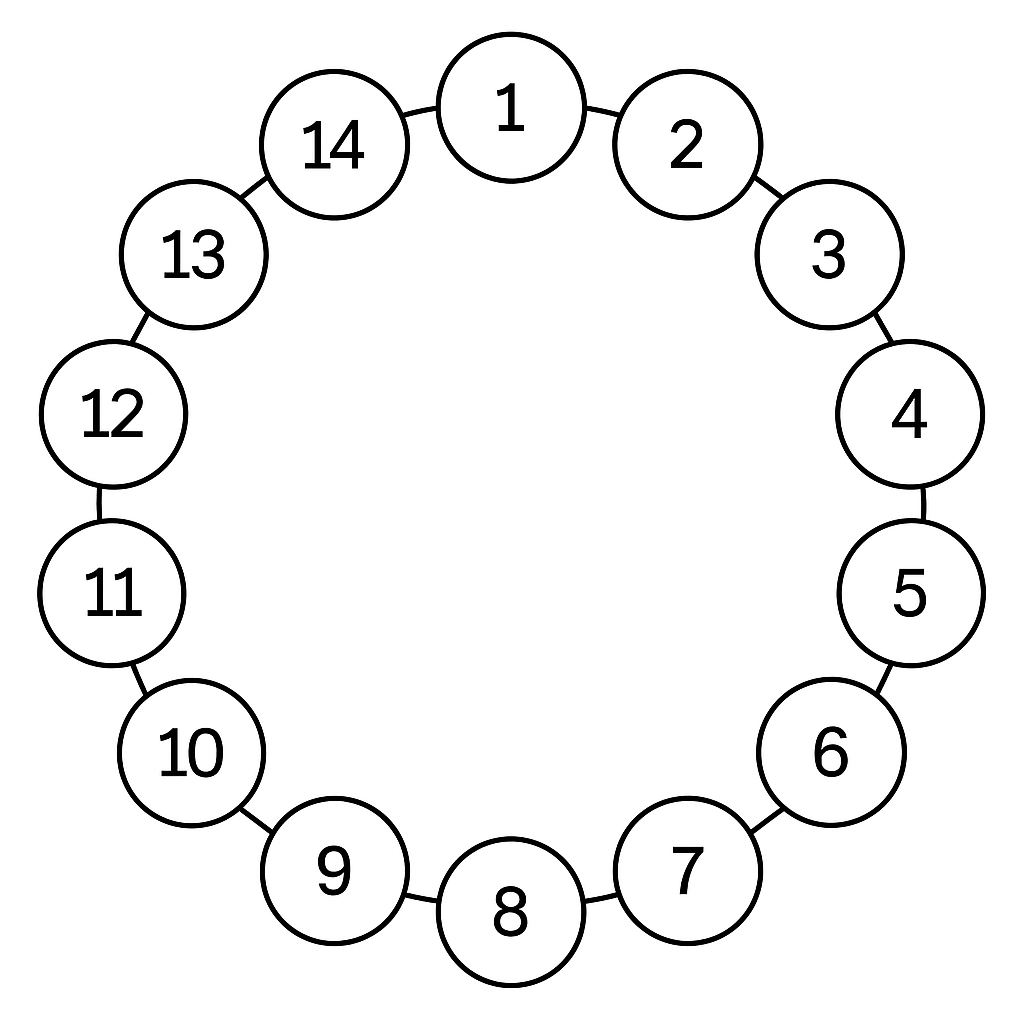

Calculate the probability of landing on each prize for different numbers of rolls:
- when the player rolls 3 dice ($X = 3$)
- when the player rolls 6 dice ($X = 6$)
- when the player rolls 15 dice ($X = 15$)

## Solution

Let the player roll $X$ six-sided dice. The total sum of the dice is $N$, and the player moves $N$ steps clockwise on the circular board. I want to find the probability $f_X(y)$ of landing on cell $y \in \{1, \dots, 14\}$.

When rolling $X$ dice, the total sum $N$ can range from $X$ to $6X$. The minimum occurs if all dice show 1, and the maximum if all dice show 6. For example, if $X = 3$, then $N \in [3, 18]$. Each sum $N$ occurs with probability $P(N)$.

Since the board is circular, the player’s final position after moving $N$ steps is

$$(13 + N) \bmod 14 + 1$$

So 
- if $N = 10$, the player lands on cell 10, 
- if $N = 16$, the player lands on cell 2.

The probability of rolling a total sum $N$ with $X$ dice is

$$P(N) = \frac{\text{number of ways to roll sum }N}{6^X}$$

Here $6^X$ is the total number of possible dice combinations.

To compute the probability of landing on a specific cell $y$, we need to sum over all possible $N$ such that

$$(13 + N) \bmod 14 + 1 = y$$

Thus, we need to sum over all values $N$ from $X$ to $6X$, but only those for which the position $(13 + N) \bmod 14 + 1 = y$

Let’s say we want to land on position 5, i.e., $f_X(5)$. Then we need such $N$ that $(13 + N) \bmod 14 + 1 = 5$
- for $X=3$, $N \in [3, 18]$ the only valid value of $N$ is 5.
- for $X=4$, $N \in [4, 24]$, the suitable values of $N$ are 5 and 19.

To find the final probability of landing on cell $y$, we have to sum the probabilities of all suitable $N$:
$$f_X(y) = \sum_{\substack{N = X \\ (13 + N) \bmod 14 + 1 = y}}^{6X} \frac{\text{number of ways to roll sum } N}{6^X}$$

That is, we iterate over all possible sums $N$ and sum those probabilities $P(N)$ for which the condition of landing on cell $y$ is satisfied.

For $X=3$ and $y=5$ we can calculate it manually:
- $N \in [3, 18]$ and only $N=5$ is suitable
- There are $6^X = 216$ possible combinations, 
- There are 6 ways to get a sum of 5 in three rolls: (1, 1, 3) and (1, 2, 2) in different permutations.

According to the formula above:

$$f_3(5) = \frac{6}{216} = \frac{1}{36} \approx 0.28$$

For larger $X$, enumerating all combinations by hand is impractical ($6^{15}$ combinations for $X=15$). To handle this, I used dynamic programming to compute the number of ways to obtain each sum $N$.

I also ran a Monte Carlo simulation to verify the analytical results. The simulated probabilities converged to the same values as the calculated ones.

## Dynamic programming solution

In [1]:
import itertools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def position(n):
    return (13 + n) % 14 + 1

def dice_sum_probabilities(x):
    sum_counter = collections.Counter({0: 1})
    for _ in range(x):
        next_sum_counts = collections.Counter()
        for current_sum in sum_counter:
            for roll in range(1, 7):
                next_sum_counts[current_sum + roll] += sum_counter[current_sum]
        sum_counter = next_sum_counts
    total = 6 ** x
    return {dice_sum: count / total for dice_sum, count in sum_counter.items()}
    
def compute_probability(x, y):
    sum_probabilities = dice_sum_probabilities(x)
    return sum(p for n, p in sum_probabilities.items() if position(n) == y)

In [3]:
positions = range(1, 15)
df = pd.DataFrame({'Space': positions})

for X in [3, 6, 15]:
    df[f'P(X={X})'] = df['Space'].apply(lambda p: compute_probability(X, p))

In [4]:
df

,Space,P(X=3),P(X=6),P(X=15)
0,1,0.046296,0.051912,0.070874
1,2,0.027778,0.057935,0.070429
2,3,0.018519,0.066615,0.070182
3,4,0.018519,0.076239,0.070182
4,5,0.027778,0.084919,0.070429
5,6,0.046296,0.090942,0.070874
6,7,0.069444,0.093107,0.071429
7,8,0.097222,0.090942,0.071983
8,9,0.115741,0.084919,0.072428
9,10,0.125000,0.076239,0.072675


$P(X=3)$ for space 5 is consistent to result in analytical solution

In [5]:
df["P(X=6)"].sum()

np.float64(0.9999999999999999)

Checking that probabilities sum to 1

## Monte Carlo modeling

In [6]:
num_trials = 10_000_000

def simulate_game(n):
    rolls = np.random.randint(1, 7, size=(num_trials, n)).sum(axis=1)
    positions = ((13 + rolls) % 14) + 1
    counts = np.bincount(positions, minlength=15)[1:15]
    probabilities = counts / num_trials
    return probabilities

In [16]:
positions = range(1, 15)
df_sim = pd.DataFrame(index=positions)

for X in [3, 6, 15]:
    probabilities = simulate_game(X)
    df_sim[f'P(X={X})'] = probabilities

In [17]:
df_sim

,P(X=4),P(X=6),P(X=15)
1,0.108034,0.051959,0.070956
2,0.096408,0.057862,0.070321
3,0.080287,0.066619,0.070172
4,0.062378,0.076219,0.070256
5,0.046370,0.084943,0.070323
6,0.034753,0.090978,0.070911
7,0.030829,0.093153,0.071482
8,0.034771,0.090898,0.072019
9,0.046357,0.084981,0.072466
10,0.062526,0.076096,0.072604


In [9]:
df_sim["P(X=15)"].sum()

np.float64(1.0)

## Insight for a player

Let’s look at how the distribution changes as the number of dice rolls \$X\$ increases.

- For $X=1$, the distribution is uniform: each outcome from 1 to 6 has probability $1/6$, and all other cells are unreachable.
- For $X=2$, the expected value is $E[N]= 2 \times 3.5 = 7$, so the distribution peaks near this value.
- For $X=3$, the expected value shifts to $E[N] = 3 \times 3.5 = 10.5$, and the distribution continues to concentrate around the mean.
- But as $X$ grows, the player repeatedly walks the 14 circular cells, so the probabilities across the cells gradually even out and tend toward a uniform distribution for large $X$.

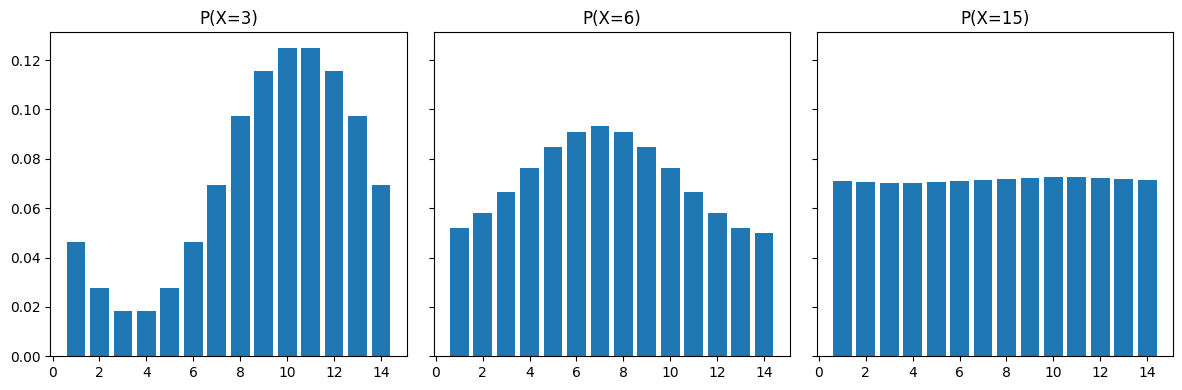

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, X in zip(axs, [3, 6, 15]):
    col = f'P(X={X})'
    ax.bar(df['Space'], df[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

So, in practice, if we are aiming for a specific cell, the optimal strategy is to pick $X$ such that the expected value $E[N]=3.5X$ lands close to that cell. For example:

- If the target cell is between 1 and 6, $X=1$ is best.
- If the target is near cell 7, $X=2$ maximizes the probability.
- For $X > 4$, targeting specific cells becomes inefficient because the distribution flattens and the probabilities converge.